# Implementation

Based on: C-Jui Hsieh et al, A Dual Coordinate Descent Method for Large-scale Linear SVM, Proceedings of
the 25th international conference on Machine learning, pp. 408-415, Helsinki, Finland, 2008  
https://icml.cc/Conferences/2008/papers/166.pdf

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [116]:
class SVM_DCD():
    def __init__(self, c):
        # initialize the model with a C hyperparameter
        assert c >= 0
        self.alpha = None
        self.x = None
        self.fitted = False
        self.C = c
        self.PG = None
        self.above = None
        self.below = None
    
    def iteration(self, i, y, z, shrink):
        # subiteration to be performed during learning; based on the algorithm 1 from the article
        # this is L1-SVM, therefore we assume U=C and D=0
        alpha0 = self.alpha[i]
        G = z * (self.x @ y) - 1
        # 3.2: shrinking
        if shrink:
            above0 = self.above if self.above > 0 else float("inf")
            below0 = self.below if self.below < 0 else float("-inf")
            if (self.alpha[i]==0 and G>above0) or (self.alpha[i]==self.C and G<below0):
                G = G*0.99
        # projected gradient
        if self.alpha[i] == 0:
            self.PG[i] = min(G, 0)
        elif self.alpha[i] == self.C:
            self.PG[i] = max(G, 0)
        else:
            self.PG[i] = G
        
        if self.PG[i] != 0:
            q = y @ y
            if q != 0:
                self.alpha[i] = min(max(self.alpha[i] - G/q, 0), self.C)
            else: # shortcut for Q_ii=0
                self.alpha[i] = self.C
            self.x = self.x + (self.alpha[i] - alpha0) * z * y
    
    def fit(self, Y: np.array, Z: np.array, k=1, eps=1e-6, shrink=False, one=False):
        nrow, ncol = Y.shape
        self.alpha = np.zeros(nrow) # the alpha vector contains as many elements as observations
        self.PG = np.zeros(nrow) # projected gradient corresponding to alpha
        self.above, self.below = 0, 0
        self.x = np.zeros(ncol) # coefficients
        # for any other initial alpha, we would assign:
        # self.x = np.sum(Z * self.alpha * Y.T, axis=1)
        
        arb_order = list(range(nrow))
        whole_set = True
        # 3.2: shrinking. First we update only a part of alphas
        if shrink:
            whole_set = False
            random.shuffle(arb_order)
            arb_order = arb_order[:(len(arb_order)//2)]
        for epoch in range(k):
            alpha0 = copy.deepcopy(self.alpha) # to compare changes later and apply early stopping
            # 3.1: random permutation of sub-problems
            order = arb_order
            random.shuffle(order)
            # 3.3: an online setting (only one alpha element updated per epoch, algorithm 2 in the article)
            if one:
                order = order[0]
            for i in order:
                self.iteration(i, Y[i], Z[i], shrink)
            # projected gradients' range (for shrinking)
            self.above = max(self.PG)
            self.below = min(self.PG)
            
            # stopping conditions
            # shrinkage
            if (shrink and epoch>0 and self.above-self.below < eps):
                if whole_set:
                    print(f"projected gradient shrunk at iteration n°{epoch}")
                    break
                else:
                    print(f"projected gradient shrunk at iteration n°{epoch}, enlarging the set")
                    arb_order = list(range(nrow))
                    self.above, self.below = 0, 0
                    whole_set = True
            # duality gap
            f1 = self.x @ self.x / 2
            loss = 1 - Z * (self.x @ Y.T)
            f2 = self.C*sum(np.where(loss<0, 0, loss))
            primal = f1+f2
            q0 = (Y.T*Z).T @ (Y.T*Z)
            dual = self.alpha @ q0 @ self.alpha / 2 - sum(self.alpha)
            if abs(primal+dual) < eps:
                print(f"duality gap closed at iteration n°{epoch}")
                break
            # decision variable stabilizes
            if np.mean(abs(alpha0-self.alpha)) < eps:
                print(f"decision variable stabilized at iteration n°{epoch}")
                break
            
            # decision function stabilizes
            if primal < eps:
                print(f"decision function stabilized at iteration n°{epoch}")
                break
        self.fitted = True
        return self
    
    def predict(self, Y: np.array):
        preds = self.x @ Y.T
        return np.sign(preds)

In [76]:
q = np.array([[3, 5], [7, 9]])
a = np.array([4, 6])
a @ q

array([54, 74])

# Sample data

## Train data

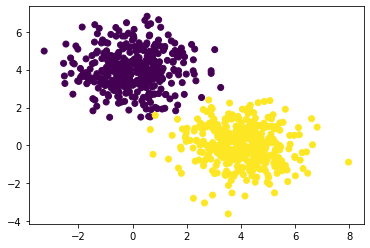

In [3]:
x1 = np.append(np.random.normal(0, 1, 400), np.random.normal(4, 1, 400))
x2 = np.append(np.random.normal(4, 1, 400), np.random.normal(0, 1, 400))
y = np.append(np.full(400, -1), np.full(400, 1))
x = np.column_stack((x1, x2))
plt.scatter(x[:, 0], x[:, 1], c=y)

## Test data (without classes)

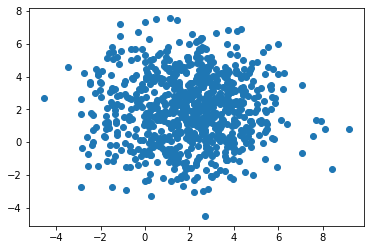

In [4]:
x1_test = np.random.normal(2, 2, 800)
x2_test = np.random.normal(2, 2, 800)
x_test = np.column_stack((x1_test, x2_test))
plt.scatter(x_test[:, 0], x_test[:, 1])

## Learning

In [117]:
model = SVM_DCD(1)

In [118]:
model.fit(x, y, k=1000, shrink=False)

duality gap closed at iteration n°196


In [119]:
p = model.predict(x_test)

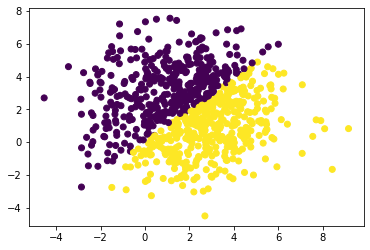

In [120]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=p)